In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import json
from datetime import datetime
import chardet
import re
import networkx as nx
import community as community_louvain
import random

In [3]:
def safe_get(dictionary, *keys):
    """Safely get a value from nested dictionaries."""
    for key in keys:
        if isinstance(dictionary, dict) and key in dictionary:
            dictionary = dictionary[key]
        else:
            return None
    return dictionary

uniqueUsers = set()
hashtagsCount = dict()
mencionesCount = dict()
mencionesMadePorUsuario = dict()
mencionesMadePorHashtag = dict()


tweets = []
with open('traficogt.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('{'):
            try:
                tweet = json.loads(line.strip())

                userName = safe_get(tweet, 'user', 'username')
                if userName is not None:
                    uniqueUsers.add(userName)

                inReplyUser = safe_get(tweet, 'inReplyToUser', 'username')
                uniqueUsers.add(inReplyUser)

                usernames = [safe_get(mention, 'username') for mention in safe_get(tweet, 'mentionedUsers')]
                usernames = [username.lower() for username in usernames if username is not None]
                usernames = [re.sub(r"[^a-z0-9 ]", '', username) for username in usernames if username is not None]


                hashtags = safe_get(tweet, 'hashtags')
                hashtags = [hashtag.lower() for hashtag in hashtags if hashtag is not None]
                hashtags = [re.sub(r"[^a-z0-9 ]", '', hashtag) for hashtag in hashtags if hashtag is not None]
                for hashtag in hashtags:
                    if hashtag in hashtagsCount:
                        hashtagsCount[hashtag] += 1
                    else:
                        hashtagsCount[hashtag] = 1


                username_len = len(usernames)

                user = userName.lower()
                if user in mencionesMadePorUsuario:
                    mencionesMadePorUsuario[user] += username_len
                    if hashtags:
                        for hashtag in hashtags:
                            mencionesMadePorHashtag[hashtag] = username_len
                else:
                    mencionesMadePorUsuario[user] = username_len
                    if hashtags:
                        for hashtag in hashtags:
                            mencionesMadePorHashtag[hashtag] = username_len

                for user in usernames:
                    uniqueUsers.add(user)
                    if user in mencionesCount:
                        mencionesCount[user] += 1
                    else:
                        mencionesCount[user] = 1

                tweets.append({
                    'date': safe_get(tweet, 'date'),
                    'content': safe_get(tweet, 'rawContent'),
                    'username': userName,
                    'replyCount': safe_get(tweet, 'replyCount'),
                    'retweetCount': safe_get(tweet, 'retweetCount'),
                    'quoteCount': safe_get(tweet, 'quoteCount'),
                    'bookmarkedCount': safe_get(tweet, 'bookmarkedCount'),
                    'likeCount': safe_get(tweet, 'likeCount'),
                    'viewCount': safe_get(tweet, 'viewCount'),
                    'inReplyToUser': inReplyUser,
                    'mentionedUsers': usernames,
                    'hashtags': safe_get(tweet, 'hashtags'),
                })
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON: {line[:50]}...")
                print(json.JSONDecodeError)
        else:
            print(f"Skipping non-JSON line: {line[:50]}...")

df = pd.DataFrame(tweets)

df

,date,content,username,replyCount,retweetCount,quoteCount,bookmarkedCount,likeCount,viewCount,inReplyToUser,mentionedUsers,hashtags
0,2024-09-12 14:22:06+00:00,Es comprensible la resolución... El ruso sabe ...,traficogt,0,0,0,0,1,393.0,None,[],[]
1,2024-09-12 00:39:56+00:00,La corrupción de la @CC_Guatemala\nes descarad...,monymmorales,0,56,4,1,84,1587.0,None,[ccguatemala],[]
2,2024-09-12 01:21:04+00:00,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,animaldgalaccia,0,0,0,0,1,91.0,PNCdeGuatemala,"[pncdeguatemala, mingobguate, fjimenezmingob, ...",[]
3,2024-09-11 20:20:01+00:00,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,EstacionDobleA,0,0,0,0,0,46.0,EstacionDobleA,"[amilcarmontejo, aztecanoticiagt, bancadasemil...",[]
4,2024-09-11 00:34:31+00:00,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,CubReserva,0,0,0,0,1,171.0,CubReserva,"[soy502, aztecanoticiagt, conapgt, denunciaemp...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...
5600,2023-10-08 21:37:45+00:00,@hshetemul @traficogt Y de igual Manera quitan...,mvtrooper,0,0,0,0,0,3.0,hshetemul,"[hshetemul, traficogt, mpguatemala, cangguatem...",[]
5601,2023-10-08 21:37:19+00:00,@traficogt Es algo más fuerte que ellos no qui...,elmeronene1,0,0,0,0,0,21.0,traficogt,[traficogt],[]
5602,2023-10-08 21:31:24+00:00,@Factor4_GT @traficogt @CC_Guatemala @MPguatem...,mvtrooper,0,0,0,0,0,4.0,Factor4_GT,"[factor4gt, traficogt, ccguatemala, mpguatemala]",[]
5603,2023-10-08 21:13:33+00:00,@AgenciaOcote @traficogt Vieja ignorante,91072dff5a5a4f1,0,0,0,0,0,17.0,AgenciaOcote,"[agenciaocote, traficogt]",[]


## Preprocesamiento de datos

### Cambios en content

In [4]:
df['content'] = df['content'].str.lower()
df['content'] = df['content'].str.replace(r'http\S+|www.\S+', '', regex=True)
df['content'] = df['content'].str.replace(r'@\S+|#\S+', '', regex=True)
df['content'] = df['content'].str.replace(r"[^a-z0-9 ]", '', regex=True)

In [5]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/darielvr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    words = text.split()
    processed_words = [word for word in words if word not in stop_words]
    return ' '.join(processed_words)

In [7]:
df['content'] = df['content'].apply(preprocess_text)

### Cambios en username

In [8]:
df['username'] = df['username'].str.lower()
df['content'] = df['content'].str.replace(r"[^a-z0-9 ]", '', regex=True)

### Cambios en inReplyToUser

In [9]:
df['inReplyToUser'] = df['inReplyToUser'].str.lower()
df['content'] = df['content'].str.replace(r"[^a-z0-9 ]", '', regex=True)

## Análisis Exploratorio

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5605 entries, 0 to 5604
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             5605 non-null   object 
 1   content          5605 non-null   object 
 2   username         5605 non-null   object 
 3   replyCount       5605 non-null   int64  
 4   retweetCount     5605 non-null   int64  
 5   quoteCount       5605 non-null   int64  
 6   bookmarkedCount  5605 non-null   int64  
 7   likeCount        5605 non-null   int64  
 8   viewCount        5601 non-null   float64
 9   inReplyToUser    4151 non-null   object 
 10  mentionedUsers   5605 non-null   object 
 11  hashtags         5605 non-null   object 
dtypes: float64(1), int64(5), object(6)
memory usage: 525.6+ KB


In [11]:
print("Cantidad de tweets: ", len(df))

Cantidad de tweets:  5605


In [12]:
print("Usuarios únicos: ",len(uniqueUsers))

Usuarios únicos:  3191


In [13]:
sortedHashtags = sorted(hashtagsCount.items(), key=lambda x: x[1], reverse=True)
print("Hashtags frecuentes: ")
for hashtag, count in sortedHashtags[:10]:
    print(f"{hashtag}: {count}")

Hashtags frecuentes: 
ahora: 30
guatemala: 25
ahoralh: 19
urgente: 16
traficogt: 16
renunciengolpistas: 15
paronacionalindefinido: 9
lahoradeactualizarnos: 8
guateresiste: 8
paronacionaindefinido: 8


In [14]:
sortedMenciones = sorted(mencionesCount.items(), key=lambda x: x[1], reverse=True)
print("Usuarios más mencionados: ")
for user, count in sortedMenciones[:10]:
    print(f"{user}: {count}")

Usuarios más mencionados: 
traficogt: 4244
barevalodeleon: 432
drgiammattei: 176
amilcarmontejo: 166
prensacomunitar: 162
mpguatemala: 138
mmendozagt: 133
lahoragt: 128
ccguatemala: 110
muniguate: 99


In [15]:
G = nx.Graph()

In [16]:
for user in uniqueUsers:
    if user is not None:
        G.add_node(user)

In [17]:
for index, row in df.iterrows():
    inReplyUsername = row['inReplyToUser']
    if inReplyUsername:
        G.add_edge(row['username'], inReplyUsername)
    
    if row['mentionedUsers']:
        for mentionedUser in row['mentionedUsers']:
            if not G.has_edge(row['username'], mentionedUser):
                G.add_edge(row['username'], mentionedUser)

### Preguntas

#### ¿Cuántos nodos sin conexiones tenemos?

In [18]:
isolated_nodes = list(nx.isolates(G))
print(f"Cantidad de nodos sin conexiones: ", len(isolated_nodes))

Cantidad de nodos sin conexiones:  1308


#### ¿Cuál fue el hashtag que generó más conexiones?

In [19]:
print(f"Hashtag con mayor cantidad de menciones hechas: {max(mencionesMadePorHashtag)}")

Hashtag con mayor cantidad de menciones hechas: zona5


#### ¿Quién fue el usuario con más menciones hechas?

In [20]:
print(f"Usuario con mayor cantidad de menciones hechas: {max(mencionesMadePorUsuario)}")

Usuario con mayor cantidad de menciones hechas: zurdoslowing


## Creación de gráfico

In [21]:
G.remove_nodes_from(isolated_nodes)

In [22]:
degree_dict = dict(G.degree(G.nodes()))

degrees = dict(G.degree())
print(degrees)

max_degree = 40
print("Max degree:", max_degree)
min_degree = min(degrees.values())
print("Min degree:", min_degree)

{'christo62617801': 7, 'sofa_melgar': 1, 'eledycito': 1, 'amedinillap': 1, 'manuel6222661': 1, 'brendah2o66': 9, 'vicentecarrera': 17, 'hoss06': 1, 'samuelpz': 54, 'canales11y13': 1, 'miquelosj': 1, 'jcchantaeu': 1, 'lagraces20': 1, 'marioomeany': 3, 'chgabriel27': 6, 'bermejogt': 7, 'vozdeltuit': 23, 'lemuslimajulioc': 2, 'semillametro': 3, 'mariaolga98': 1, 'hrooseveltgt': 1, 'eabril89': 2, 'cijicj': 1, 'luciatzikin': 3, 'wechalal': 1, 'random_ram80': 2, 'enandopz': 4, 'colemanusaid': 2, 'pialaperiodista': 32, 'oracintfaith': 4, 'josmchacn2': 5, 'gt502_luis': 2, 'mariochen76': 1, 'mixco': 1, 'esnaoro1': 1, 'sc_nashi': 3, 'teoriadelacons1': 1, 'luisperea11': 1, 'bancadasemilla': 27, 'franciscoxutuc': 1, 'mingobguate': 23, 'silvia13fernand': 5, '87kikin': 8, 'zarahlu': 3, 'yohenbarrera': 3, 'wsantizo': 2, 'polipelaez': 3, 'jmeggs': 1, 'sperezattias': 13, 'noti7guatemala': 5, 'tonogtr': 4, 'punionista': 1, 'dicledafar': 2, 'panchopa1': 5, 'emisorasunidas': 53, 'rafamal0072': 18, 'julioa

In [23]:
cmap = plt.cm.viridis

node_colors = []
for node in G.nodes():
    degree = degrees[node]

    norm_degree = (degree - min_degree) / (max_degree - min_degree) if max_degree > min_degree else 0
    node_colors.append(cmap(norm_degree))

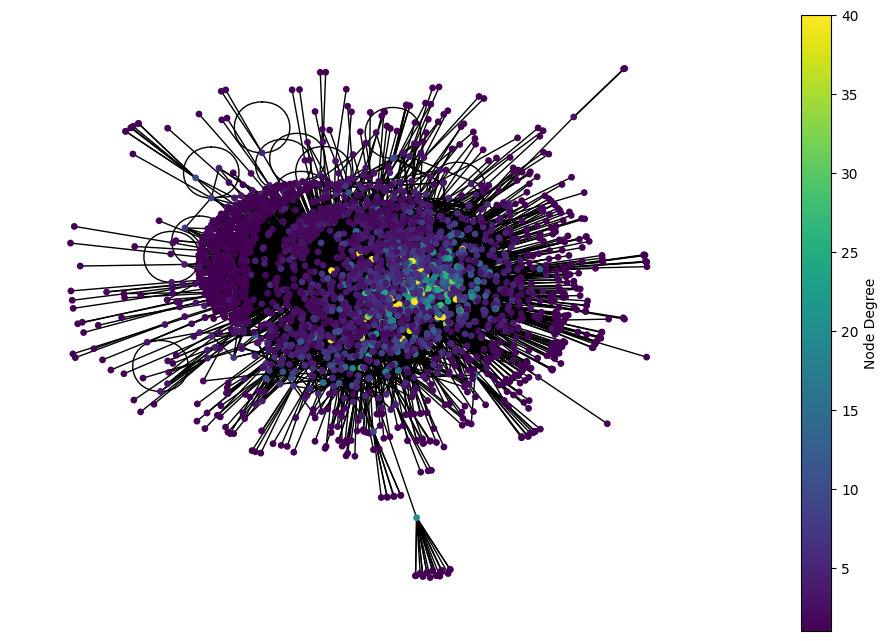

In [24]:
plt.figure(figsize=(12, 8))
ax = plt.gca()

pos = nx.spring_layout(G)

nx.draw(G, pos, node_color=node_colors, node_size=15, ax=ax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_degree, vmax=max_degree))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Node Degree', orientation='vertical', pad=0.1)

plt.show()

### Densidad de la red

In [25]:
densidad = nx.density(G)
print("Densidad: ", densidad)

Densidad:  0.0019301240636359622


### Diámetro de la red

In [26]:
def check_connectivity(G):
    if G.is_directed():
        print("El grafo es dirigido.")
        print(f"¿Está fuertemente conectado? {nx.is_strongly_connected(G)}")
        print(f"¿Está débilmente conectado? {nx.is_weakly_connected(G)}")
    else:
        print("El grafo es no dirigido.")
        print(f"¿Está conectado? {nx.is_connected(G)}")

    if G.is_directed():
        num_strong = nx.number_strongly_connected_components(G)
        num_weak = nx.number_weakly_connected_components(G)
        print(f"Número de componentes fuertemente conectados: {num_strong}")
        print(f"Número de componentes débilmente conectados: {num_weak}")
    else:
        num_components = nx.number_connected_components(G)
        print(f"Número de componentes conectados: {num_components}")

    if G.is_directed():
        largest_strong = max(nx.strongly_connected_components(G), key=len)
        largest_weak = max(nx.weakly_connected_components(G), key=len)
        print(f"Tamaño de la componente fuertemente conectada más grande: {len(largest_strong)}")
        print(f"Tamaño de la componente débilmente conectada más grande: {len(largest_weak)}")
    else:
        largest = max(nx.connected_components(G), key=len)
        print(f"Tamaño de la componente conectada más grande: {len(largest)}")

In [27]:
check_connectivity(G)

El grafo es no dirigido.
¿Está conectado? True
Número de componentes conectados: 1
Tamaño de la componente conectada más grande: 2856


In [28]:
diametro = nx.diameter(G)
print("Diámetro de la red: ", diametro)

Diámetro de la red:  7


### Coeficiente de agrupamiento

In [29]:
coef_agrupamiento = nx.average_clustering(G)
print("Coeficiente de agrupamiento: ", coef_agrupamiento)

Coeficiente de agrupamiento:  0.20917984183902746


### Encontrar comunidades utilizando algoritmo de Louvain

In [30]:
def detect_communities(G):
    
    partition = community_louvain.best_partition(G)
    
    return partition

In [31]:
def visualize_graph_with_communities(G, partition):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    
    num_communities = max(partition.values()) + 1
    colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))
    random.shuffle(colors)
    
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size=300, 
                               node_color=[colors[com]], label=f"Community {com}")
    
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    
    plt.title("Communities Detected with Louvain Algorithm")
    plt.legend(scatterpoints=1, loc='lower left', ncol=3, fontsize=8, bbox_to_anchor=(0,1.02,1,0.2))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [32]:
def find_biggest_community(partition):

    community_sizes = {}
    for node, community_id in partition.items():
        if community_id not in community_sizes:
            community_sizes[community_id] = 0
        community_sizes[community_id] += 1
    
    biggest_community_id = max(community_sizes, key=community_sizes.get)
    biggest_community_size = community_sizes[biggest_community_id]
    
    return biggest_community_id, biggest_community_size, community_sizes

In [33]:
partition = detect_communities(G)

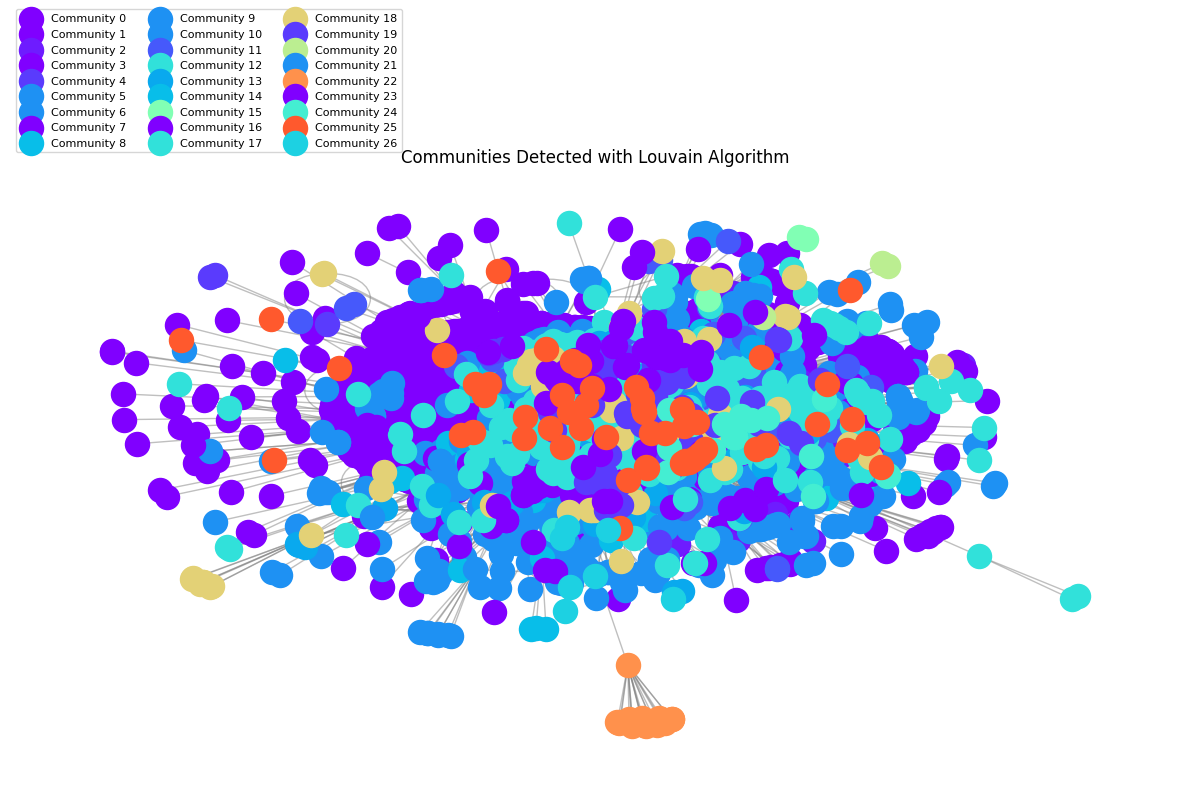

In [34]:
visualize_graph_with_communities(G, partition)

In [35]:
biggest_community_id, biggest_community_size, community_sizes = find_biggest_community(partition)

print(f"The biggest community is community {biggest_community_id} with {biggest_community_size} nodes.")
print("\nAll community sizes:")

sortedCommunities = dict(sorted(community_sizes.items(), key=lambda item: item[1], reverse=True))

for i, (community_id, size) in enumerate(sortedCommunities.items()):
    if i >= 10:
        break
    print(f"Community {community_id} -> size: {size}")

The biggest community is community 1 with 778 nodes.

All community sizes:
Community 1 -> size: 778
Community 6 -> size: 219
Community 9 -> size: 217
Community 5 -> size: 184
Community 3 -> size: 177
Community 0 -> size: 170
Community 17 -> size: 163
Community 7 -> size: 133
Community 12 -> size: 98
Community 10 -> size: 84


In [36]:
from collections import Counter

def find_top_3_communities(partition):
    community_sizes = Counter(partition.values())
    return [comm for comm, _ in community_sizes.most_common(3)]

def create_top_3_communities_graph(G, partition):
    top_3_communities = find_top_3_communities(partition)
    
    new_G = nx.Graph()
    
    for node, comm in partition.items():
        if comm in top_3_communities:
            new_G.add_node(node, community=comm)
    
    for edge in G.edges():
        if new_G.has_node(edge[0]) and new_G.has_node(edge[1]):
            new_G.add_edge(*edge)
    
    return new_G, top_3_communities

def visualize_top_3_communities_graph(new_G, top_3_communities):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(new_G)
    
    colors = ['#FF9999', '#66B2FF', '#99FF99']
    
    for i, comm in enumerate(top_3_communities):
        list_nodes = [node for node, data in new_G.nodes(data=True) if data['community'] == comm]
        nx.draw_networkx_nodes(new_G, pos, list_nodes, node_size=300, 
                               node_color=colors[i], label=f"Community {comm}")
    
    nx.draw_networkx_edges(new_G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(new_G, pos, font_size=2, font_weight='bold')
    
    plt.legend(scatterpoints=1, loc='lower left', ncol=3, fontsize=10, bbox_to_anchor=(0,1.02,1,0.2))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

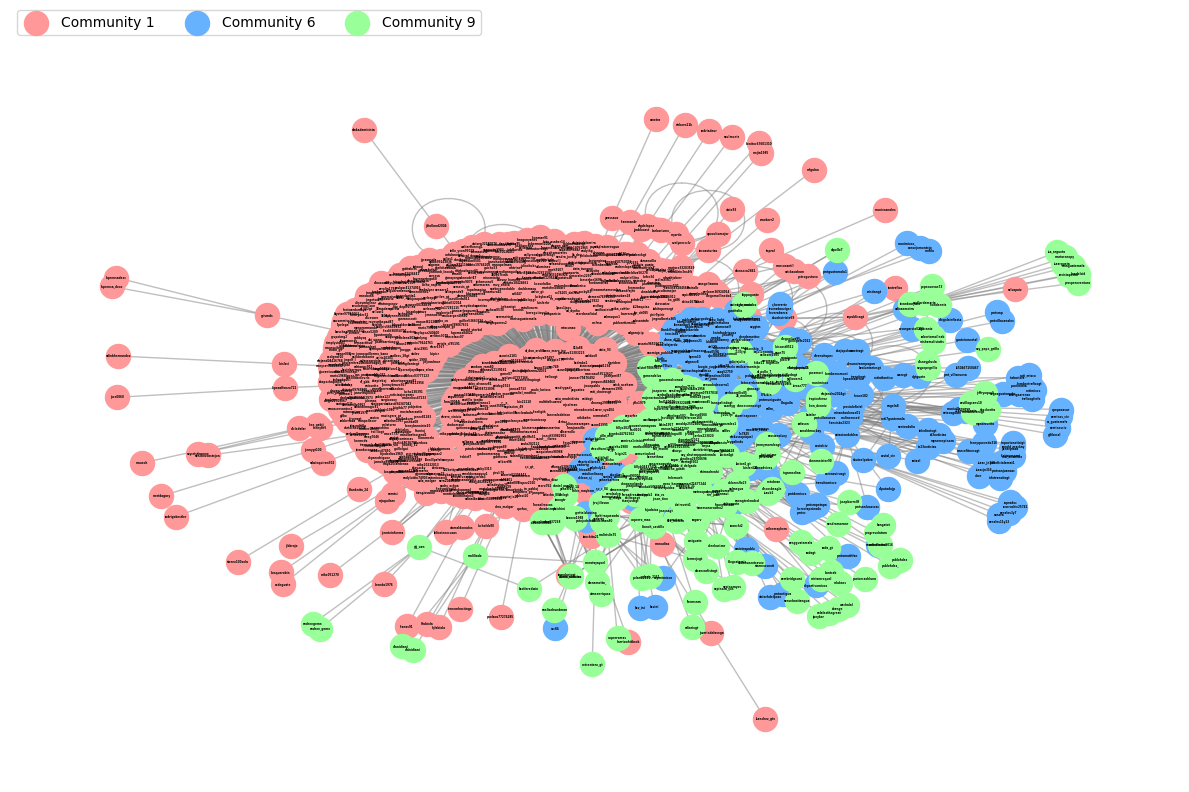

In [37]:
new_G, top_3_communities = create_top_3_communities_graph(G, partition)
visualize_top_3_communities_graph(new_G, top_3_communities)

# Influencers y nodos clave

In [38]:
# Centralidad del grafo: Usuarios con más conexiones directas (menciones o retweets)
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_degree_centrality[:10]

[('traficogt', 0.6795096322241682),
 ('barevalodeleon', 0.11453590192644483),
 ('mildred_gaitan', 0.04868651488616463),
 ('drgiammattei', 0.04693520140105079),
 ('prensacomunitar', 0.04553415061295972),
 ('batallonjalapa', 0.04203152364273205),
 ('mmendozagt', 0.03852889667250438),
 ('mpguatemala', 0.03642732049036778),
 ('lahoragt', 0.03292469352014011),
 ('amilcarmontejo', 0.03187390542907181)]

In [39]:
# Centralidad de intermediación: Usuarios que actuan como puentes entre comunidades
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_betweenness_centrality[:10]

[('traficogt', 0.8980272330699612),
 ('mildred_gaitan', 0.027284204461174934),
 ('batallonjalapa', 0.026460904819577902),
 ('barevalodeleon', 0.022244716495807497),
 ('jalenvelaz46026', 0.01326800987215534),
 ('chofito63569841', 0.012495704004938315),
 ('erwin15', 0.00793446288334744),
 ('giovanottigt', 0.007331745273167114),
 ('cubreserva', 0.006979698800485046),
 ('miss_pattygt', 0.00697828366158138)]

In [40]:
# Centralidad de cercanía: Usuarios que pueden llegar a todos los demás nodos con la menor cantidad de saltos.
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_closeness_centrality[:10]

[('traficogt', 0.7513157894736842),
 ('barevalodeleon', 0.4892887746358183),
 ('drgiammattei', 0.4694179546201907),
 ('mmendozagt', 0.46589425587467365),
 ('mpguatemala', 0.46422764227642277),
 ('lahoragt', 0.4629479487595265),
 ('jlfont001', 0.4594464113292565),
 ('emisorasunidas', 0.45527029181948653),
 ('congresoguate', 0.45483511231480006),
 ('msemillagt', 0.4544730977395734)]

# Grupos Aislados

In [41]:
# Identificar grupos o subcomunidades aisladas dentro de cada red, que interactúan muy poco con el resto.
def find_isolated_groups(G, partition):
    isolated_groups = {}
    
    for node, comm in partition.items():
        neighbors = set(G.neighbors(node))
        neighbor_comms = set(partition[n] for n in neighbors)
        
        if len(neighbor_comms) == 1:
            isolated_groups[comm] = isolated_groups.get(comm, 0) + 1

    isolated_groups = {k: (v / sortedCommunities[k]) for k, v in isolated_groups.items()}
    
    return isolated_groups

isolated_groups = find_isolated_groups(G, partition)
sorted_isolated_groups = sorted(isolated_groups.items(), key=lambda x: x[1], reverse=True)
sorted_isolated_groups[:10]

[(22, 0.95),
 (1, 0.9485861182519281),
 (14, 0.75),
 (15, 0.6666666666666666),
 (20, 0.6666666666666666),
 (4, 0.6666666666666666),
 (21, 0.6666666666666666),
 (26, 0.5714285714285714),
 (3, 0.480225988700565),
 (10, 0.34523809523809523)]

In [42]:
# Analisis de sentimientos en cada comunidad
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment'] = df['content'].apply(analyze_sentiment)

def analyze_sentiment_in_communities(partition, df):
    sentiment_by_community = {comm: [] for comm in set(partition.values())}
    
    for node, comm in partition.items():
        tweets = df[df['username'] == node]
        sentiment = tweets['sentiment'].mean()
        # Check that sentiment is not NaN
        if sentiment == sentiment:
            sentiment_by_community[comm].append(sentiment)
    
    return sentiment_by_community

sentiment_by_community = analyze_sentiment_in_communities(partition, df)
sentiment_by_community = {comm: sum(sentiments) / len(sentiments) for comm, sentiments in sentiment_by_community.items()}
sorted_sentiment_by_community = sorted(sentiment_by_community.items(), key=lambda x: x[1], reverse=True)

for comm, sentiment in sorted_sentiment_by_community:
    sentiment_label = "Positive" if sentiment > 0.01 else "Negative" if sentiment < -0.01 else "Neutral"
    print(f"Community {comm} -> Average sentiment: {sentiment} ({sentiment_label})")

Community 11 -> Average sentiment: 0.013218390804597701 (Positive)
Community 19 -> Average sentiment: 0.011482558139534884 (Positive)
Community 16 -> Average sentiment: 0.0071428571428571435 (Neutral)
Community 7 -> Average sentiment: 0.006156475103843526 (Neutral)
Community 25 -> Average sentiment: 0.005544263775971093 (Neutral)
Community 6 -> Average sentiment: 0.005092592592592593 (Neutral)
Community 5 -> Average sentiment: 0.003667068411386594 (Neutral)
Community 23 -> Average sentiment: 0.003486542443064182 (Neutral)
Community 13 -> Average sentiment: 0.0028623949579831935 (Neutral)
Community 24 -> Average sentiment: 0.0023269980506822616 (Neutral)
Community 2 -> Average sentiment: 0.0018756887052341596 (Neutral)
Community 18 -> Average sentiment: 0.001749377836334358 (Neutral)
Community 1 -> Average sentiment: 0.0014298201227426089 (Neutral)
Community 17 -> Average sentiment: 0.00018132228309219455 (Neutral)
Community 4 -> Average sentiment: 0.0 (Neutral)
Community 14 -> Average 

In [43]:
# Analisis de topicos en cada comunidad
from bertopic import BERTopic


topic_model = BERTopic(language="spanish")
found_topics, probability = topic_model.fit_transform(df['content'])


/home/darielvr/Escritorio/Data/SocialMediaAnalysis-DataScience/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2279,-1_si_ser_ms_solo,"[si, ser, ms, solo, est, ahora, estn, mp, as, qu]",[dos pueden deben hacer est puesto sacar corru...
1,0,402,0____,"[, , , , , , , , , ]","[, , ]"
2,1,373,1_guatemala_guatemaltecos_nicaragua_pueblo,"[guatemala, guatemaltecos, nicaragua, pueblo, ...","[nicaragua guatemala dictadura, corruptos pueb..."
3,2,218,2_est_ah_qu_shoooooooooooooo,"[est, ah, qu, shoooooooooooooo, chucho, sho, a...",[campaa consuelo porras pido autorice toda que...
4,3,167,3_corruptos_corrupcin_corrupto_pacto,"[corruptos, corrupcin, corrupto, pacto, corrup...","[corruptos, corruptos, corruptos]"
...,...,...,...,...,...
77,76,11,76_twitter_celular_tigo_sociales,"[twitter, celular, tigo, sociales, ayudaran, a...",[opino cosas aisladas q ver si in twitter irre...
78,77,11,77_mes_familiares_familias_cuanto,"[mes, familiares, familias, cuanto, trabajador...",[visto despachan cuchara grande trabajadores m...
79,78,10,78_malditos_bajn_169_cocina,"[malditos, bajn, 169, cocina, depravados, pudr...","[pedfilos depravados sxu si u, maldita hora ap..."
80,79,10,79_sentencia_doble_castigo_multas,"[sentencia, doble, castigo, multas, conmutable...",[tiempo resulten sentencia conmutabletambin de...


In [48]:
def analyze_topics_in_communities(partition, topics):
    topics_by_community = {comm: [] for comm in set(partition.values())}
    
    for node, comm in partition.items():
        tweets: pd.DataFrame = df[df['username'] == node]
        tweet_topics = []
        for index, tweet in tweets.iterrows():
            if topics[index] > 0:
                tweet_topics.append(topics[index])
        topics_by_community[comm].extend(tweet_topics)
    
    return topics_by_community

topics_by_community = analyze_topics_in_communities(partition, found_topics)
topics_by_community = {comm: Counter(topics).most_common(5) for comm, topics in topics_by_community.items()}
        
topics_by_community

{0: [(1, 30), (2, 11), (3, 8), (15, 8), (7, 7)],
 1: [(1, 104), (2, 79), (3, 48), (5, 32), (31, 29)],
 2: [(1, 17), (2, 6), (17, 4), (3, 4), (56, 3)],
 3: [(1, 22), (3, 16), (7, 6), (13, 6), (5, 5)],
 4: [],
 5: [(1, 21), (2, 14), (3, 12), (6, 7), (7, 6)],
 6: [(25, 23), (20, 22), (1, 18), (62, 11), (2, 9)],
 7: [(1, 18), (2, 16), (3, 9), (6, 9), (12, 7)],
 8: [(1, 14), (2, 4), (4, 4), (26, 4), (22, 4)],
 9: [(1, 33), (2, 18), (3, 15), (9, 8), (15, 8)],
 10: [(2, 10), (1, 6), (3, 4), (12, 3), (42, 3)],
 11: [(3, 6), (8, 5), (1, 5), (14, 4), (37, 4)],
 12: [(1, 11), (2, 6), (27, 6), (44, 4), (16, 4)],
 13: [(1, 5), (6, 4), (11, 4), (10, 3), (3, 3)],
 14: [],
 15: [(60, 1)],
 16: [(2, 4), (3, 3), (32, 2), (35, 2), (11, 1)],
 17: [(1, 17), (3, 15), (2, 14), (7, 5), (4, 5)],
 18: [(1, 14), (3, 5), (11, 4), (4, 4), (2, 4)],
 19: [(1, 12), (28, 4), (3, 3), (76, 3), (2, 3)],
 20: [],
 21: [(13, 1)],
 22: [],
 23: [(1, 8), (2, 6), (4, 4), (3, 3), (9, 3)],
 24: [(1, 6), (28, 3), (9, 3), (4, 2),

In [49]:
for comm, topics in topics_by_community.items():
    print(f"\nCommunity {comm} Topics:")
    for topic_id, _ in topics:
        keywords = topic_model.get_topic(topic_id)[:10]
        # Get only the keywords for the topic
        keywords = [keyword for keyword, _ in keywords]
        print(f"Topic {topic_id}: {keywords}")


Community 0 Topics:
Topic 1: ['guatemala', 'guatemaltecos', 'nicaragua', 'pueblo', 'the', 'presidente', 'democracia', 'of', 'gobierno', 'guatemalteco']
Topic 2: ['est', 'ah', 'qu', 'shoooooooooooooo', 'chucho', 'sho', 'ahora', 'ms', 'aldana', 'campaa']
Topic 3: ['corruptos', 'corrupcin', 'corrupto', 'pacto', 'corrupta', 'corrupcion', 'parte', 'igual', 'semilla', 'ahora']
Topic 15: ['juez', 'jueces', 'suspender', 'penal', 'magistrados', 'provisional', 'norma', 'corte', 'abogado', 'justicia']
Topic 7: ['dinero', 'fondos', 'depositos', 'pagos', 'pagarlo', 'millonada', 'falta', 'adis', 'pagar', 'favores']

Community 1 Topics:
Topic 1: ['guatemala', 'guatemaltecos', 'nicaragua', 'pueblo', 'the', 'presidente', 'democracia', 'of', 'gobierno', 'guatemalteco']
Topic 2: ['est', 'ah', 'qu', 'shoooooooooooooo', 'chucho', 'sho', 'ahora', 'ms', 'aldana', 'campaa']
Topic 3: ['corruptos', 'corrupcin', 'corrupto', 'pacto', 'corrupta', 'corrupcion', 'parte', 'igual', 'semilla', 'ahora']
Topic 5: ['voto

In [59]:
# Obtener temas más comunes de usuario 
def get_user_topics(username, df, topics):
    user_topics = []
    for index, row in df.iterrows():
        if row['username'] == username or row['inReplyToUser'] == username or username in row['mentionedUsers']:
            if topics[index] > 0:
                user_topics.append(topics[index])
    
    user_topics = Counter(user_topics).most_common(5)
    return user_topics
   
print("Tópicos más comunes en @traficogt:")         
traficogt_topics = get_user_topics("traficogt", df, found_topics)
for topic_id, _ in traficogt_topics:
    keywords = topic_model.get_topic(topic_id)[:10]
    keywords = [keyword for keyword, _ in keywords]
    print(f"Topic {topic_id}: {keywords}")
        
print("\nTópicos más comunes en @barevalodeleon:")    
bernardo_topics = get_user_topics("barevalodeleon", df, found_topics)
for topic_id, _ in bernardo_topics:
    keywords = topic_model.get_topic(topic_id)[:10]
    keywords = [keyword for keyword, _ in keywords]
    print(f"Topic {topic_id}: {keywords}")


Tópicos más comunes en @traficogt:
Topic 1: ['guatemala', 'guatemaltecos', 'nicaragua', 'pueblo', 'the', 'presidente', 'democracia', 'of', 'gobierno', 'guatemalteco']
Topic 2: ['est', 'ah', 'qu', 'shoooooooooooooo', 'chucho', 'sho', 'ahora', 'ms', 'aldana', 'campaa']
Topic 3: ['corruptos', 'corrupcin', 'corrupto', 'pacto', 'corrupta', 'corrupcion', 'parte', 'igual', 'semilla', 'ahora']
Topic 7: ['dinero', 'fondos', 'depositos', 'pagos', 'pagarlo', 'millonada', 'falta', 'adis', 'pagar', 'favores']
Topic 8: ['ustedes', 'va', 'si', 'vas', 'anda', 'ests', 'gusta', 'dime', 'preguntar', 'andas']

Tópicos más comunes en @barevalodeleon:
Topic 1: ['guatemala', 'guatemaltecos', 'nicaragua', 'pueblo', 'the', 'presidente', 'democracia', 'of', 'gobierno', 'guatemalteco']
Topic 6: ['presidente', 'presidencial', 'jimmy', 'presidencia', 'morales', 'nacional', 'ser', 'seguridad', 'asunto', 'sueos']
Topic 3: ['corruptos', 'corrupcin', 'corrupto', 'pacto', 'corrupta', 'corrupcion', 'parte', 'igual', 'se